# Feature Selection, Scenario Testing, and Stacking Notebook
This notebook includes full preprocessing, PCA, univariate feature selection, scenario testing, stacking, feature importances, and grid search tuning.

In [34]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [35]:
# --- Load Data ---
embeddings_df = pd.read_csv('out/embeddings_processed.csv')
structured_df = pd.read_csv('out/data.csv')

# Convert embedding strings to float
embeddings_df = embeddings_df['embedding'].str.split(',', expand=True).astype(float)
embeddings_df.columns = [f'emb_{i}' for i in range(embeddings_df.shape[1])]

data = pd.concat([embeddings_df, structured_df], axis=1)
data = data.drop(columns=['cases.submitter_id'])

# Separate X and y
y = data['OS']
X = data.drop(columns=['OS'])

In [36]:
# --- Preprocessing ---
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype(str)
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=['object']).columns

num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])

if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X[cat_cols] = pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), columns=cat_cols, index=X.index)

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le

In [37]:
# --- Feature Groups ---
embedding_cols = [col for col in X.columns if col.startswith('emb_')]
data_cols = [col for col in X.columns if not col.startswith('emb_')]
print(f'Embedding features: {len(embedding_cols)}, Structured features: {len(data_cols)}')

Embedding features: 768, Structured features: 19


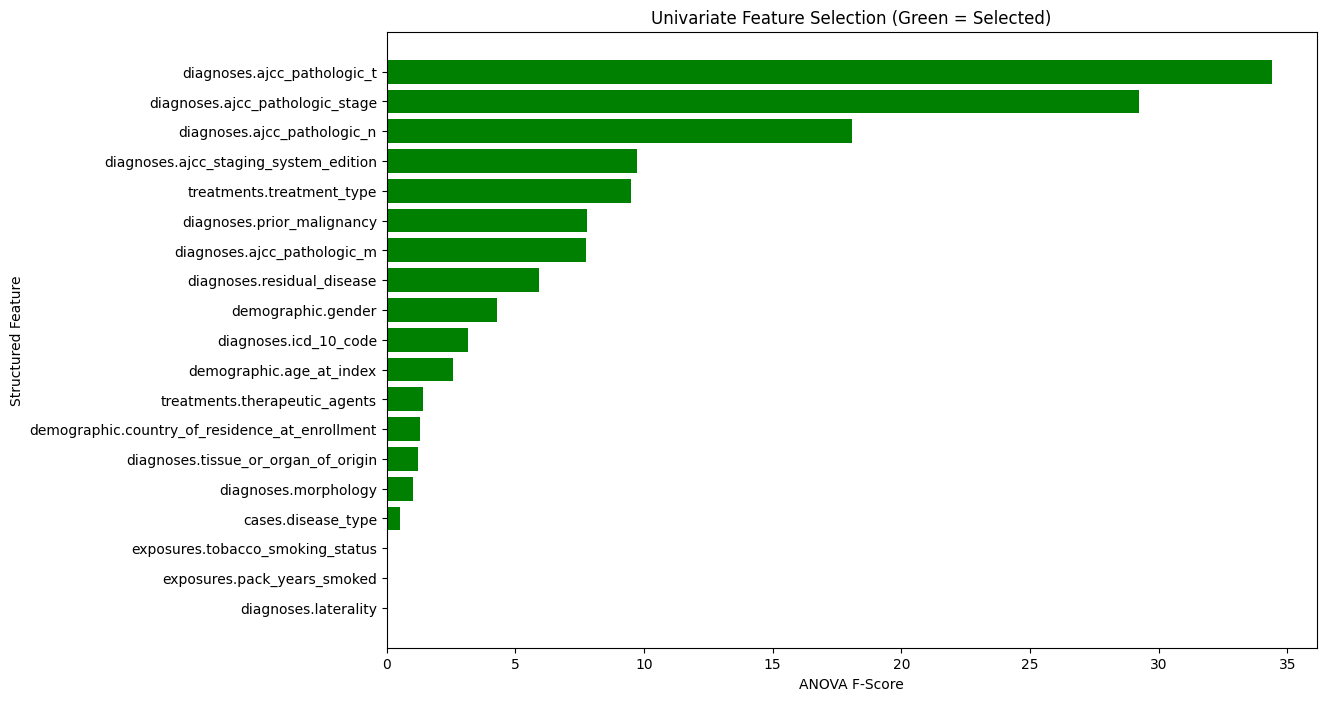

In [38]:
# --- Univariate Feature Selection ---
univariate_selector = SelectKBest(f_classif, k='all')
univariate_selector.fit(X[data_cols], y)
scores = univariate_selector.scores_
selected = univariate_selector.get_support()

feature_scores_df = pd.DataFrame({
    'Feature': data_cols,
    'F-score': scores,
    'Selected': selected
}).sort_values('F-score', ascending=True)

# Plot univariate scores
plt.figure(figsize=(12,8))
plt.barh(feature_scores_df['Feature'], feature_scores_df['F-score'], color=['green' if s else 'gray' for s in feature_scores_df['Selected']])
plt.xlabel('ANOVA F-Score')
plt.ylabel('Structured Feature')
plt.title('Univariate Feature Selection (Green = Selected)')
plt.show()

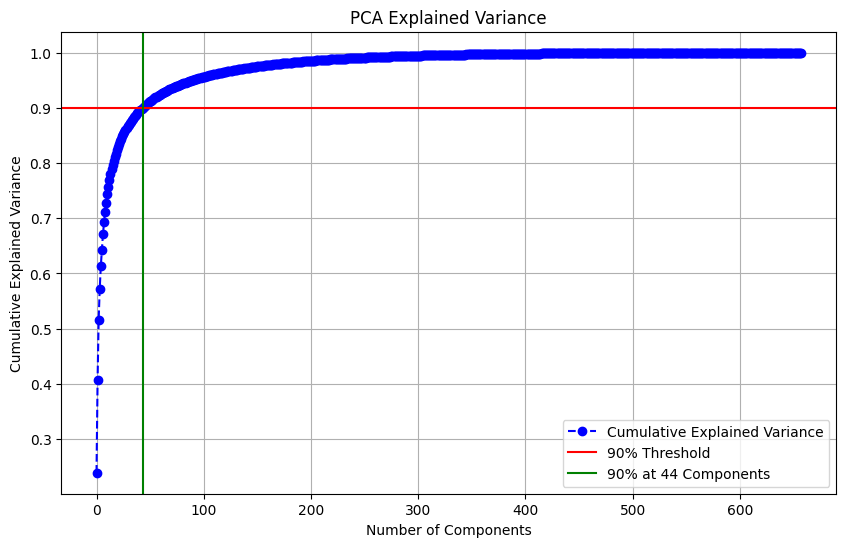

Recommended n_components to capture 90% variance: 44


In [39]:
# --- PCA on Embeddings ---
scaler_emb = StandardScaler()
X_emb_scaled = scaler_emb.fit_transform(X[embedding_cols])

# Find optimal components for 90% variance
pca_all = PCA(n_components=None)
pca_all.fit(X_emb_scaled)
cumulative_variance = np.cumsum(pca_all.explained_variance_ratio_)
components_90 = np.argmax(cumulative_variance >= 0.90) + 1

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='blue', label='Cumulative Explained Variance')
plt.axhline(y=0.90, color='red', linestyle='-', label='90% Threshold')
plt.axvline(x=components_90-1, color='green', linestyle='-', label=f'90% at {components_90} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()
print(f'Recommended n_components to capture 90% variance: {components_90}')

In [40]:
# --- Scenario Testing: Structured, Embedding, Combined ---
# Pipelines
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=5))])
structured_pipeline = Pipeline([('scaler', StandardScaler())])

# Combined
preprocessor_combined = ColumnTransformer([
    ('pca_transform', pca_pipeline, embedding_cols),
    ('structured_scale', structured_pipeline, data_cols)
], remainder='drop', n_jobs=-1)
X_combined = preprocessor_combined.fit_transform(X)

# Structured only
preprocessor_structured = ColumnTransformer([
    ('structured_scale', structured_pipeline, data_cols),
    ('drop_embeddings', 'drop', embedding_cols)
], remainder='drop', n_jobs=-1)
X_structured_only = preprocessor_structured.fit_transform(X)

# Embedding only
preprocessor_embedding = ColumnTransformer([
    ('pca_transform', pca_pipeline, embedding_cols),
    ('drop_structured', 'drop', data_cols)
], remainder='drop', n_jobs=-1)
X_embedding_only = preprocessor_embedding.fit_transform(X)

def evaluate_rf(X_input, y, name=''):
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_input, y, cv=skf, scoring='roc_auc', n_jobs=-1)
    print(f'{name} Mean ROC AUC: {scores.mean():.4f}, Std: {scores.std():.4f}')
    return scores

cv_structured = evaluate_rf(X_structured_only, y, 'Structured Only')
cv_embedding = evaluate_rf(X_embedding_only, y, 'Embedding Only')
cv_combined = evaluate_rf(X_combined, y, 'Combined Data')

Structured Only Mean ROC AUC: 0.6964, Std: 0.0446
Embedding Only Mean ROC AUC: 0.5013, Std: 0.0482
Combined Data Mean ROC AUC: 0.6922, Std: 0.0495


In [41]:
# --- Stacked Model ---
# Manual stacking using OOF predictions
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_predictions = np.zeros((X.shape[0], 2))

for train_idx, val_idx in skf.split(X, y):
    X_s_train, X_s_val = X_structured_only[train_idx], X_structured_only[val_idx]
    X_e_train, X_e_val = X_embedding_only[train_idx], X_embedding_only[val_idx]
    y_train = y.iloc[train_idx]
    
    m_s = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
    m_s.fit(X_s_train, y_train)
    oof_predictions[val_idx, 0] = m_s.predict_proba(X_s_val)[:,1]
    
    m_e = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
    m_e.fit(X_e_train, y_train)
    oof_predictions[val_idx, 1] = m_e.predict_proba(X_e_val)[:,1]

meta_model = LogisticRegression(solver='liblinear', random_state=42)
meta_model.fit(oof_predictions, y)

stack_auc = roc_auc_score(y, oof_predictions.mean(axis=1))
meta_auc = roc_auc_score(y, meta_model.predict_proba(oof_predictions)[:,1])
print(f'Simple Average Stacking AUC: {stack_auc:.4f}')
print(f'Meta-Model Stacked AUC: {meta_auc:.4f}')

Simple Average Stacking AUC: 0.6486
Meta-Model Stacked AUC: 0.6957


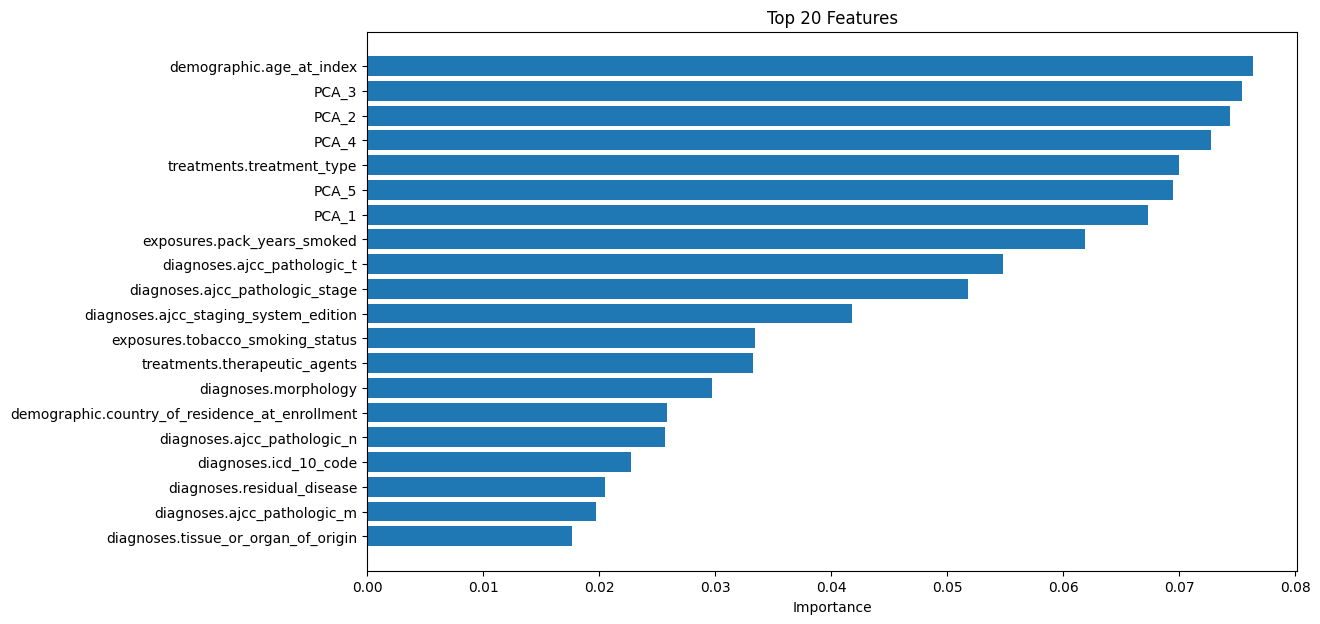

                            Feature  Importance
6          demographic.age_at_index    0.076340
2                             PCA_3    0.075409
1                             PCA_2    0.074372
3                             PCA_4    0.072734
21        treatments.treatment_type    0.070018
4                             PCA_5    0.069492
0                             PCA_1    0.067348
22      exposures.pack_years_smoked    0.061896
12      diagnoses.ajcc_pathologic_t    0.054776
11  diagnoses.ajcc_pathologic_stage    0.051752


In [42]:
# --- Feature Importances ---
final_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
final_model.fit(X_combined, y)

num_pca = X_combined.shape[1] - len(data_cols)
pca_feature_names = [f'PCA_{i+1}' for i in range(num_pca)]
all_feature_names = pca_feature_names + data_cols
importances = final_model.feature_importances_

feat_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(12,7))
plt.barh(feat_df['Feature'].head(20), feat_df['Importance'].head(20))
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 20 Features')
plt.show()
print(feat_df.head(10))

In [43]:
# --- Prune features based on importance ---
IMPORTANCE_THRESHOLD = 0.005
important_features_df = feat_df[feat_df['Importance'] >= IMPORTANCE_THRESHOLD]
FINAL_FEATURE_LIST = important_features_df['Feature'].tolist()

final_pca_features = [f for f in FINAL_FEATURE_LIST if f.startswith('PCA_')]
final_structured_features = [f for f in FINAL_FEATURE_LIST if not f.startswith('PCA_')]
final_pca_indices = [int(f.split('_')[1])-1 for f in final_pca_features]
structured_start_index = len(pca_feature_names)
structured_name_to_index = {name:i for i,name in enumerate(data_cols)}
final_structured_indices = [structured_start_index + structured_name_to_index[name] for name in final_structured_features]
all_final_indices = sorted(final_pca_indices + final_structured_indices)
X_pruned = X_combined[:, all_final_indices]

cv_pruned = evaluate_rf(X_pruned, y, 'Pruned Combined Data')

Pruned Combined Data Mean ROC AUC: 0.6922, Std: 0.0495


In [44]:
# --- Grid Search on Structured Data Only ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt','log2']
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid, scoring='roc_auc', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), verbose=2, n_jobs=-1)
grid_search.fit(X_structured_only, y)
print('Best params:', grid_search.best_params_)
print('Best mean ROC AUC:', grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_sa